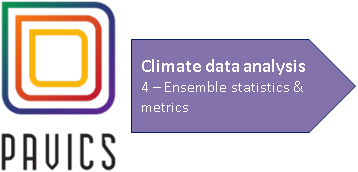
<a id='top'></a>

PAVICS ensemble functionalities rely on the [xclim ensembles](https://xclim.readthedocs.io/en/stable/notebooks/ensembles.html) module. Ensembles are an important aspect of climate change studies due to various sources of uncertainty in future climate projections and the associated need of their robust incorporation when attempting to produce actionable climate change information products. This fouth tutorial will present PAVICS tools for ensemble dataset creation, statistics and metrics accessing output netcdf files created in the previous tutorial on climate indicators. 

This tutorial outlines steps for:

* [Ensemble dataset creation](#create_ens)
* [Ensemble statistics](#ens_stat)
* [Ensemble robustness](#ens_metric)


___

*NOTES:*  
*To run this series of tutorials in the PAVICS jupyterhub, notebooks should be copied into your 'writable-workspace' directory*  
*Advanced topics not covered by this tutorial : [Ensemble reduction](https://xclim.readthedocs.io/en/stable/notebooks/ensembles-advanced.html#)*  




<a id='create_ens'></a>

## Ensemble dataset creation
The ensembles module allows us to easily concatenate multiple netcdf outputs into a single logical dataset via [`create_ensemble`](https://xclim.readthedocs.io/en/stable/notebooks/ensembles.html#create_ensemble). We will re-use the output netcdf files of the tutorial three's advanced section, where we used a realtively simple workflow to calculate a climate indicator on all (n=22) simulations in the `cb-oura-1.0` ensemble.  Note the additional data dimension `realization` which is created.

*[return to top of page](#top)*

2021-02-16 10:44:44,033 - root - INFO - Accessing output/tx_days_above_27_degC-YS_BNU-ESM_historical+rcp45_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1981-2100.nc of 11
2021-02-16 10:44:44,060 - root - INFO - Accessing output/tx_days_above_27_degC-YS_NorESM1-M_historical+rcp45_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1981-2100.nc of 11
2021-02-16 10:44:44,080 - root - INFO - Accessing output/tx_days_above_27_degC-YS_GFDL-ESM2M_historical+rcp45_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1981-2100.nc of 11
2021-02-16 10:44:44,101 - root - INFO - Accessing output/tx_days_above_27_degC-YS_CMCC-CMS_historical+rcp45_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1981-2100.nc of 11
2021-02-16 10:44:44,112 - root - INFO - Accessing output/tx_days_above_27_degC-YS_MPI-ESM-LR_historical+rcp45_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1981-2100.nc of 11
2021-02-16 10:44:44,121 - root - INFO - Accessing output/tx_days_above_27_degC-YS_IPSL-CM5B-LR_historical+rcp45_r1i1p1_na10kgrid_qm-moving-50bins-detre

<xarray.Dataset>
Dimensions:        (lat: 12, lon: 60, realization: 11, time: 120)
Coordinates:
  * time           (time) datetime64[ns] 1981-01-01 1982-01-01 ... 2100-01-01
  * lat            (lat) float32 48.96 48.87 48.79 48.71 ... 48.21 48.12 48.04
  * lon            (lon) float32 -68.96 -68.88 -68.8 ... -64.21 -64.13 -64.05
  * realization    (realization) int64 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    tx_days_above  (realization, time, lat, lon) float64 dask.array<chunksize=(1, 120, 12, 60), meta=np.ndarray>

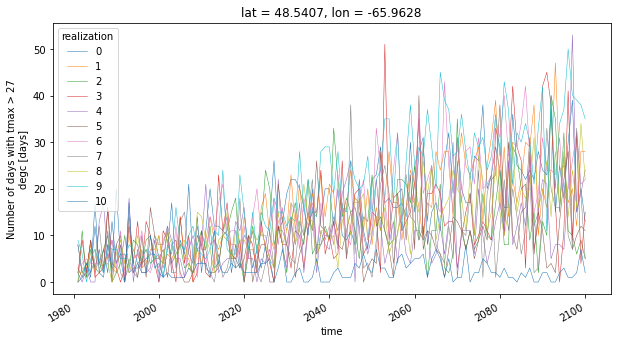

In [1]:
from xclim import ensembles as xens
from clisops.core import subset
from pathlib import Path
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

infolder = Path('output')

# Create a list of rcp 4.5 files  (n=11)
ncfiles = [d for d in infolder.glob('*rcp45*.nc')]

#Create an ensemble dataset from the 11 simulations
ds_ens = xens.create_ensemble(ncfiles)
display(ds_ens)

# Plot time series of single grid point
lon = -66
lat = 48.5

subset.subset_gridpoint(ds_ens, lon=lon, lat=lat).tx_days_above.plot.line(figsize=(10,5), x='time' ,linewidth=0.5)
#plt.title('RCP 4.5 individuals runs : ')
display()

___
<a id='ens_stat'></a>
### Ensemble statistics
We can now employ functions for calculating statistics between realizations including calculating [ensemble percentiles](https://xclim.readthedocs.io/en/stable/notebooks/ensembles.html#Ensemble-percentiles) as well as [ensemble mean, standard-deviation, maximum & minimum](https://xclim.readthedocs.io/en/stable/notebooks/ensembles.html#Ensemble-statistics) values
  

*[return to top of page](#top)*

<xarray.Dataset>
Dimensions:        (lat: 12, lon: 60, percentiles: 3, time: 120)
Coordinates:
  * time           (time) datetime64[ns] 1981-01-01 1982-01-01 ... 2100-01-01
  * lat            (lat) float32 48.96 48.87 48.79 48.71 ... 48.21 48.12 48.04
  * lon            (lon) float32 -68.96 -68.88 -68.8 ... -64.21 -64.13 -64.05
  * percentiles    (percentiles) int64 10 50 90
Data variables:
    tx_days_above  (time, lat, lon, percentiles) float64 dask.array<chunksize=(120, 12, 60, 3), meta=np.ndarray>
Attributes:
    xclim_history:  [2021-02-16 10:44:44] : Computation of the percentiles on...

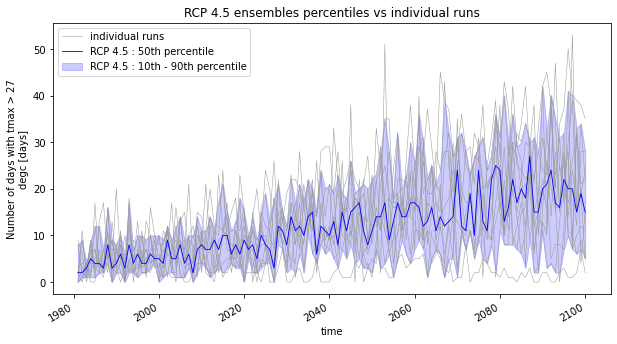

In [2]:
# Calculate percentiles
ds_perc = xens.ensemble_percentiles(ds_ens, values=[10, 50, 90], split=False)
display(ds_perc)
# compare with indiviudual runs
subset.subset_gridpoint(ds_ens, lon=lon, lat=lat).tx_days_above.plot.line(label='individual runs',color=[0.6, .6 , .6],figsize=(10,5),x='time' ,linewidth=0.5)
perc1 = subset.subset_gridpoint(ds_perc, lon=lon, lat=lat).tx_days_above

plt.fill_between(color='b',label="RCP 4.5 : 10th - 90th percentile",x=perc1.time.values, y1=perc1.sel(percentiles=10), y2=perc1.sel(percentiles=90), alpha=0.2)
subset.subset_gridpoint(ds_perc, lon=lon, lat=lat).tx_days_above.sel(percentiles=50).plot(label="RCP 4.5 : 50th percentile",color='b', linewidth=.85, )

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.title('RCP 4.5 ensembles percentiles vs individual runs')
display()

___

<a id='ens_metric'></a>
### Ensemble robustness metrics
PAVICS [robustness metrics](https://xclim.readthedocs.io/en/stable/api.html#ensemble-robustness-metrics) can be used to estimate the confidence of the climate change signal. Currently a small number of metrics are implemented based on the IPCC's fifth assessment report : [IPCC AR5 WG1 - chapter 12](https://www.ipcc.ch/site/assets/uploads/2018/02/WG1AR5_Chapter12_FINAL.pdf) (see box 12.1) 


*[return to top of page](#top)*

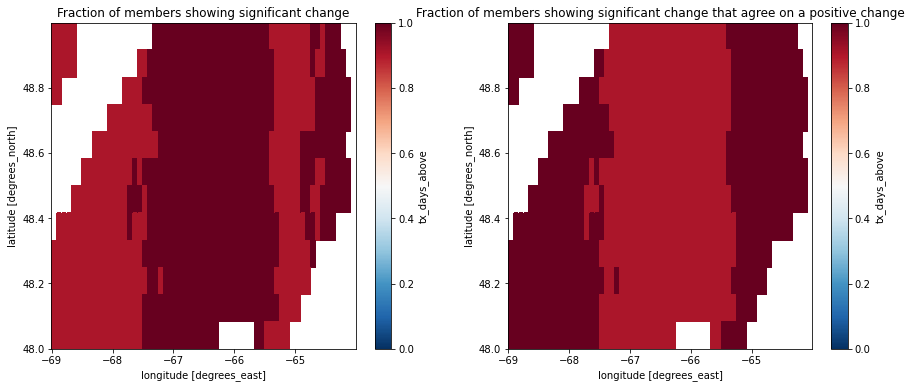

In [3]:
fut = ds_ens.sel(time=slice('2071', '2100')).chunk(dict(realization=-1)) 
ref = ds_ens.sel(time=slice('1990', '2020')).chunk(dict(realization=-1))
chng_f, pos_f = xens.change_significance(fut, ref, test='ttest')
plt.figure(figsize=(15,6),)

plt.subplot(1,2,1)
chng_f.tx_days_above.plot(cmap='RdBu_r', vmin=0, vmax=1)

plt.title(chng_f.description.split('.')[0])

plt.subplot(1,2,2)
pos_f.tx_days_above.plot(cmap='RdBu_r', vmin=0, vmax=1)
plt.title(pos_f.description.split('.')[0])

display()